# Risk of cancer prediction for patients with multiple disorders

Scientists have created a model to predict the risk of suffering cancer for people who suffer multiple disorders. This model is expected to save lives .

The same scientist published the details of their research, how the model was built and a detailed description of the data (e.g., the health conditions investigated), the NHS board where the data was collected. The data was deidentified and was not released as it is confidential patient information, and any leak might break existing legislation.

The researchers balanced the benefits and potential risks of the model realease, and it was decided that overall, there is a clear benefit for the population for the model to be made public.

## Is there anyone famous in the training data?

What they didn’t realise, is that the NHS board in question is where a famous MP goes to. This famous MP was a former PM, and it is of public knowledge he suffered from cancer. Also, it is straightforward for anyone to do an online search and find some other details like age (62) and weight (overweight).

## Malintentioned user

Someone, who has the right technical background, has just realised that the famous person could have been included in the study. If it is the case, this hacker can attack the model and to find out data of about the MP details and sell out succulent information for potentially large amounts of money. Otherwise, the hacker will only loose the time, but thinks it is still worth the effort.

## How can the attacker find out information 

To perform an attack is not trivial. The attacker has read and understood the publication and believes to be capable to recreate some fake data to resemble the data used in the model, as the publication include quite a lot of details (expected from this type of journals). These details include the range of features (diabetes, asthma, BMI group, blood pressure group, smoker, age), any criteria used to include or reject participants, which will be helpful to recreate the data set, the age range of the participants, the number of participants included that suffer from cancer the number who did not (100 of each), and where and when the data was collected. On the technical side, it says that the model was built using an SVM using the scikit-learn library with the hyper-parameter combination of probability set to true and gamma to 0.2.


Then this malefactor builds a similar model with the fake data. This new fake model is then used to create a second model that identifies whether a given patient data was included or not in the original model.

The hacker will also need to determine all the possible combinations of data for the famous MP that could have been included in the model. The age, weight and cancer status are known, but not the rest. So, the attacker has 48 possibilities about the MP health condition, and only one is true. This potential health data for the MP is queried to the target model to determine whether it was part of the model. If the number of queries allowed to the original or target model were limited, then the rate of successful attacks drops dramatically. However, in this example anyone can perform as many queries as the model as desired.

Here is a diagram of how the attack is performed.

![Attack](images/Salem_scenario_diagram.png)

## Attacker's findings

After performing the attack, the hacker is confident that the MP was part of the study, smokes and suffers from diabetes and asthma. However, it is not capable to determine the blood pressure. As this information is unknown to the public, the hacker can try to sell it, for example to tabloids, for potentially large amount of cash.


# Let's get hands on with this example.

In [1]:
import random
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from scipy.stats import norm
from itertools import product

# Create the original model

In the original model 100 cancer patients and 100 non cancer patients were selected.

As we don't have access to the NHS data for creating this toy model, we need to invent it. For now we are creating 99 data point for cancer and 100 for non-cancer. Later on we'll add the data of your MP to the set.

In [2]:
#1 is cancer, 0 is no cancer, this is our label and what we want to predict.
cancer = [1]*99 + [0]*100

df = pd.DataFrame()

#diabetes 0 no, 1 yes
df['diabetes'] = [[1, 0][random.random()>0.7] for n in range(99)] +[[1, 0][random.random()>0.2] for n in range(100)]

#asthma 0 no, 1 yes
df['asthma'] = [[1, 0][random.random()>0.7] for n in range(99)] + [[1, 0][random.random()>0.5] for n in range(100)]

#bmi group 1 under, 2 normal, 3 overweight, 4 obese
df['bmi_group'] = [random.choices([1, 2, 3, 4], weights = [0.5, 5, 7, 5], k = 1)[0] for n in range(99)] + [random.choices([1, 2, 3, 4], weights = [1, 7, 4, 1], k = 1)[0] for n in range(100)]

#blood pressure 0 is low, 1 is normal, 5 is extremly high
df['blood_pressure'] = [random.choices([0, 1, 2, 3, 4, 5], weights = [0.5, 1, 5, 6, 1, 0.5], k = 1)[0] for n in range(99)] + [random.choices([0, 1, 2, 3, 4, 5], weights = [0.5, 5, 5, 1, 1, 0.5], k = 1)[0] for n in range(100)]

#smoker 0 is non smoker, 1 is smoker
df['smoker'] = [[1, 0][random.random()>0.8] for n in range(99)] + [[1, 0][random.random()>0.2] for n in range(100)]

#age
x = np.arange(20,90)
pmf = poisson.pmf(x,72)
age = [random.choices(x, weights = pmf, k = 1)[0] for n in range(99)]
x = np.arange(20,90)
pmf = poisson.pmf(x,55)
age2 = [random.choices(x, weights = pmf, k = 1)[0] for n in range(100)]
df['age'] = age + age2

We are now going to add the data of your MP.

Let's imagine that data you don't about your MP health:
- diabetes
- asthma
- blood pressure, slightly bit high (group 2)
- smoker

In [3]:
#Add the data of your MP
cancer = cancer + [1]

#add new row to end of DataFrame
#the order of the list indicates in order diabetes, asthma, bmi_group, blood_pressure, smoker, age
df.loc[len(df.index)] = [1, 1, 3, 2, 1, 62]

In [4]:
df

,diabetes,asthma,bmi_group,blood_pressure,smoker,age
0,1,0,3,3,1,77
1,1,1,3,2,1,60
2,1,0,2,1,1,75
3,1,1,2,2,0,66
4,0,0,3,2,1,84
...,...,...,...,...,...,...
195,0,1,2,2,1,66
196,1,1,2,2,0,62
197,0,0,2,2,1,61
198,0,0,2,2,0,56


Let's have a look at the distrubution of our data.

diabetes cancer


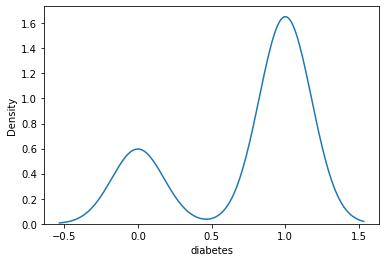

diabetes no cancer


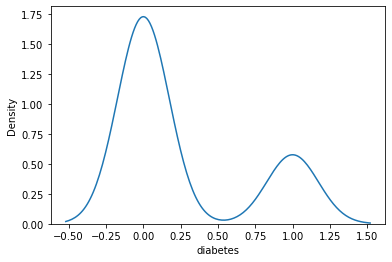

asthma cancer


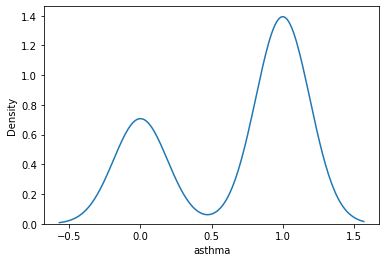

asthma no cancer


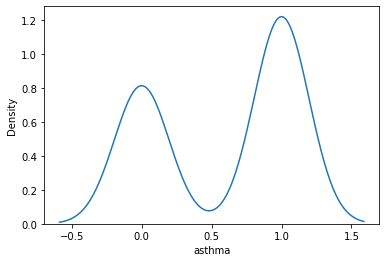

bmi_group cancer


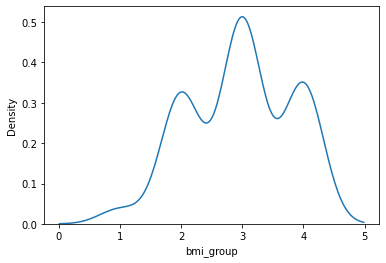

bmi_group no cancer


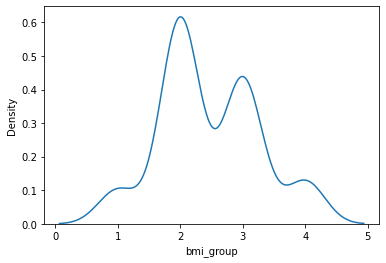

blood_pressure cancer


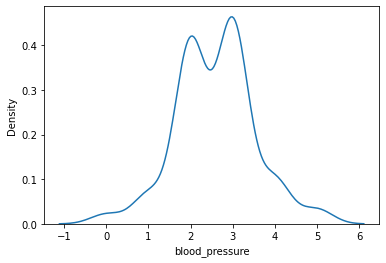

blood_pressure no cancer


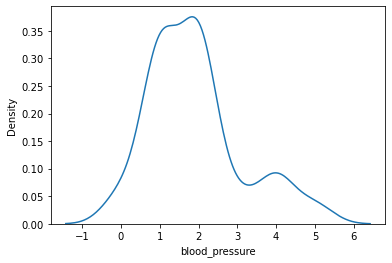

smoker cancer


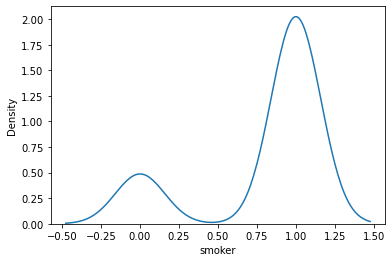

smoker no cancer


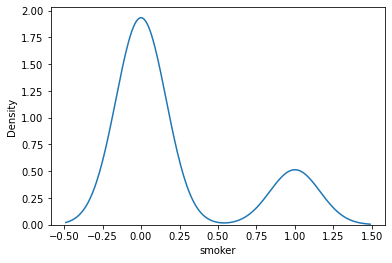

age cancer


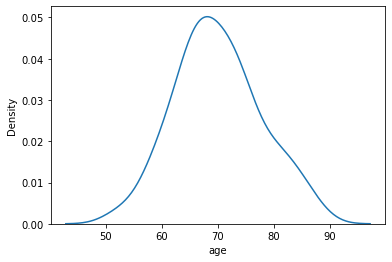

age no cancer


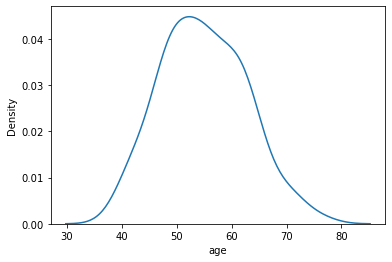

In [5]:
for x in df.columns:
    print(x, 'cancer')
    sns.kdeplot(df[:98][x])
    plt.show()
    print(x, 'no cancer')
    sns.kdeplot(df[98:198][x])
    plt.show()

In [6]:
#Check if any other patient data coincides with the one of your MP
df[(df.diabetes==1) & (df.asthma==1) & (df.bmi_group==3) & (df.blood_pressure==2) & (df.smoker==1) & (df.age==62)]

,diabetes,asthma,bmi_group,blood_pressure,smoker,age
199,1,1,3,2,1,62


Split the data for test and train of the target (or original) model.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df, cancer,
                                                    train_size=0.7,
                                                    random_state=100,
                                                    stratify=cancer)

The next functions are to calculate the metrics to evaluate the models.

In [8]:
def min_max_disc(
    y_true,
    pred_probs,
    x_prop=0.1,
    log_p=True):
    '''
    Non-average-case methods for MIA attacks. Considers actual frequency of membership
    amongst samples with highest- and lowest- assessed probability of membership. If an
    MIA method confidently asserts that 5% of samples are members and 5% of samples are
    not, but cannot tell for the remaining 90% of samples, then these metrics will flag
    this behaviour, but AUC/advantage may not. Since the difference may be noisy, a
    p-value against a null of independence of true membership and assessed membership
    probability (that is, membership probabilities are essentially random) is also used
    as a metric (using a usual Gaussian approximation to binomial). If the p-value is
    low and the frequency difference is high (>0.5) then the MIA attack is successful
    for some samples.
    Parameters
        y: true labels
        yp: probabilities of labels, or monotonic transformation of probabilties
        xprop=0.1: proportion of samples with highest- and lowest- probability of membership to be
            considered
        logp=True: convert p-values to log(p).
    Returns:
        maxd: frequency of y=1 amongst proportion xprop of individuals with highest assessed
            membership probability
        mind: frequency of y=1 amongst proportion xprop of individuals with lowest assessed
            membership probability
        mmd: difference between maxd and mind
        pval: p-value or log-p value corresponding to mmd against null hypothesis that random
            variables corresponding to y and yp are independent.
    '''

    n_examples = int(np.round(len(y_true) * x_prop))
    pos_frequency = np.mean(y_true) # average frequency
    y_order = np.argsort(pred_probs) # ordering permutation

    # Frequencies
    # y values corresponding to lowest k values of yp
    y_lowest_n = y_true[y_order[:n_examples]]
    # y values corresponding to highest k values of yp
    y_highest_n = y_true[y_order[-(n_examples):]]
    maxd = np.mean(y_highest_n)
    mind = np.mean(y_lowest_n)
    mmd = maxd - mind

    # P-value
    # mmd is asymptotically distributed as N(0,sdm^2) under null.
    sdm = np.sqrt(2 * pos_frequency * (1 - pos_frequency) / n_examples)
    pval = 1 - norm.cdf(mmd, loc=0, scale=sdm) # normal CDF
    if log_p:
        if pval< 1e-50:
            pval=-115.13
        else: 
            pval=np.log(pval)

    # Return
    return maxd, mind, mmd, pval

In [9]:
VAR_THRESH = 1e-2

def div(x,y, default):
    '''
    Solve the problem of division by 0 and round up.
    '''
    if y!=0:
        return round(float(x/y),8)
    else:
        #print('Warning: division by 0', x,y)
        return float(default)


def get_metrics(clf,
                X_test,
                y_test,
                permute_rows=True):
    """
    Calculate metrics, including attacker advantage for MIA binary.
    Implemented as Definition 4 on https://arxiv.org/pdf/1709.01604.pdf
    which is also implemented in tensorFlow-privacy https://github.com/tensorflow/privacy

    clf: fitted model.
    X_test: test data.
    y_test: test data labels.

    returns a dictionary with several metrics.

    True positive rate or recall (TPR)
    False positive rate (FPR), proportion of negative examples incorrectly classified as positives
    False alarm rate (FAR), proportion of objects classified as positives that are incorrect, also known as false discovery rate
    True neagative rate (TNR)
    Positive predictive value or precision (PPV)
    Negative predictive value (NPV)
    False neagative rate (FNR)
    Accuracy (ACC)
    F1 Score - harmonic mean of precision and recall.
    Advantage
    """
    metrics = {}
    if permute_rows:
        N, _ = X_test.shape
        order = np.random.permutation(N)
        X_test = X_test[order, :]
        y_test = y_test[order]
    y_pred = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    #print('tn', tn, 'fp',fp,'fn', fn,'tp', tp)

    metrics['TPR'] = round(float(tp/(tp + fn)), 8) #true positive rate or recall
    metrics['FPR'] = round(float(fp / (fp + tn)), 8) #false positive rate, proportion of negative examples incorrectly classified as positives
    metrics['FAR'] = div(fp, (fp + tp), 0) #False alarm rate, proportion of things classified as positives that are incorrect, also known as false discovery rate
    metrics['TNR'] = round(float(tn / (tn + fp)), 8) #true negative rate or specificity
    metrics['PPV'] = div(tp, (tp + fp), 0) #precision or positive predictive value
    metrics['NPV'] = div(tn, (tn + fn), 0) #negative predictive value
    metrics['FNR'] = round(float(fn / (tp + fn)), 8) #false negative rate
    metrics['ACC'] = round(float((tp + tn) / (tp + fp + fn + tn)), 8) #overall accuracy
    metrics['F1score'] = div(2*metrics['PPV']*metrics['TPR'], metrics['PPV']+metrics['TPR'], 0)#harmonic mean of precision and sensitivity
    metrics['Advantage'] = float(abs(metrics['TPR']-metrics['FPR']))
    #calculate AUC of model
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    metrics['AUC'] = round(roc_auc_score(y_test, y_pred_proba),8)

    fmax, fmin, fdif, pdif = min_max_disc(y_test, y_pred_proba)
    metrics['FMAX'] = fmax
    metrics['FMIN'] = fmin
    metrics['FDIF'] = fdif
    metrics['PDIF'] = -pdif # use -log(p) so answer is positive

    # Add some things useful for debugging / filtering
    metrics['pred_prob_var'] = y_pred_proba.var()

    return metrics

In [10]:
svm = SVC(probability=True, gamma=0.1)
svm.fit(x_train, y_train)
accuracy = svm.score(x_train, y_train)
print( f'Training set accuracy = {100*accuracy}%')

Training set accuracy = 93.57142857142857%


# Potential data for your MP health

You now want to find out if your MP was part of the dataset, and if so, which is the part of his health you didn't know so far. To do so, you start with the data you have (cancer, age 62, BMI overweight which correspond to group 3). Since you know the rest of the data included in the study, you only need to make up values for the rest.

We call this set "fictional MP health" as we don't know which of the possibilities is true (only one can be).

In [11]:
d = {'diabetes' : [0,1],
     'asthma' : [0,1], 
     'bmi_group' : [3], #known data
     'blood_pressure' : [0,1,2,3,4,5],
     'smoker' :[0,1],
     'age':[62] #known data
    }

fictional_MP_health = pd.DataFrame()
all_combinations = product(*d.values())
g = {}
for _, combination in enumerate(all_combinations):
    # Turn this particular combination into a dictionary
    g[_] = {n: v for n, v in zip(d.keys(), combination)}
fictional_MP_health = pd.DataFrame(g).T

#labels for the fictional MP health
cancer_MP = [1]*len(fictional_MP_health)
print(len(cancer_MP))
fictional_MP_health

48


,diabetes,asthma,bmi_group,blood_pressure,smoker,age
0,0,0,3,0,0,62
1,0,0,3,0,1,62
2,0,0,3,1,0,62
3,0,0,3,1,1,62
4,0,0,3,2,0,62
5,0,0,3,2,1,62
6,0,0,3,3,0,62
7,0,0,3,3,1,62
8,0,0,3,4,0,62
9,0,0,3,4,1,62


# Membership inference attack

For performing the attack, you decided to build a shadow model with data of the same distribution. First, you'll invent some data that could resemble what was used in the model.

In this example the shadow data is built similarly to the target model dataset.

## Steps for the attack:
1- Create a shadow data of similar distribution.

2- Split shadow data into test and train.

3- Build the shadow model.

4- Calculate accuracy.

5- Create the data for membership inference attack.

6- Obtain the probability of data belonging or not the to target (or original) model training set.

In [13]:
invented_cancer = [1]*100 + [0]*100

invented_data = pd.DataFrame()

#diabetes 0 no, 1 yes
invented_data['diabetes'] = [[1, 0][random.random()>0.8] for n in range(100)] +[[1, 0][random.random()>0.3] for n in range(100)]

#asthma 0 no, 1 yes
invented_data['asthma'] = [[1, 0][random.random()>0.6] for n in range(100)] + [[1, 0][random.random()>0.4] for n in range(100)]

#bmi group 1 under, 2 normal, 3 overweight, 4 obese
invented_data['bmi_group'] = [random.choices([1, 2, 3, 4], weights = [1, 10, 15, 5], k = 1)[0] for n in range(100)] + [random.choices([1, 2, 3, 4], weights = [2, 10, 10, 2], k = 1)[0] for n in range(100)]

#blood pressure 0 is low, 1 is normal, 5 is extremly high
invented_data['blood_pressure'] = [random.choices([0, 1, 2, 3, 4, 5], weights = [1, 2, 10, 10, 5, 0.1], k = 1)[0] for n in range(100)] + [random.choices([0, 1, 2, 3, 4, 5], weights = [1, 10, 10, 1, 1, 0.1], k = 1)[0] for n in range(100)]

#smoker (1) or not (0)
invented_data['smoker'] = [[1, 0][random.random()>0.8] for n in range(100)] + [[1, 0][random.random()>0.1] for n in range(100)]

#age
x = np.arange(20,90)
pmf = poisson.pmf(x,70)
age = [random.choices(x, weights = pmf, k = 1)[0] for n in range(100)]
x = np.arange(20,90)
pmf = poisson.pmf(x,50)
age2 = [random.choices(x, weights = pmf, k = 1)[0] for n in range(100)]
invented_data['age'] = age + age2
invented_data

,diabetes,asthma,bmi_group,blood_pressure,smoker,age
0,1,0,3,0,1,69
1,0,1,4,4,1,83
2,1,0,4,0,1,71
3,1,0,4,2,1,56
4,1,1,4,3,1,74
...,...,...,...,...,...,...
195,0,0,3,1,0,36
196,0,1,3,1,0,49
197,1,1,3,2,0,50
198,0,1,3,4,1,48


In [14]:
#Create shadow model
def create_mia_data(clf,
                    xtrain,
                    xtest,
                    sort_probs,
                    keep_top=-1):
    """
    This function predict the probability of train and test data
    (from building the model split) belonging to their
    corresponding train or test respectively
    and it also creates labels.

    clf: fitted classifier (target model)
    xtrain: training data (target model)
    xtest: test data (target model)
    sort_probs: sort rows by highest probability. Default: False.
    """
    miX = np.concatenate(
        (
            clf.predict_proba(xtrain),
            clf.predict_proba(xtest)
        )
    )

    if sort_probs:
        miX = -np.sort(-miX, axis=1)
        if keep_top > -1:
            miX = miX[:, :keep_top]

    miY = np.concatenate(
        (
        np.ones((len(xtrain), 1), int),
        np.zeros((len(xtest), 1), int)
        )
    ).flatten()
    return(miX,miY)


def salem(target_model,
          shadow_clf,
          X_target_train,
          X_shadow,
          y_shadow,
          X_test,
          prop_shadow_train=0.5,
          mia_classifier=RandomForestClassifier()):
    X_shadow_train, X_shadow_test, y_shadow_train, y_shadow_test = train_test_split(X_shadow, y_shadow, train_size=prop_shadow_train)

    shadow_clf.fit(X_shadow_train, y_shadow_train)

    mia_train_probs, mia_train_labels = create_mia_data(shadow_clf, X_shadow_train, X_shadow_test, sort_probs=True)
    mia_test_probs, mia_test_labels = create_mia_data(target_model, X_target_train, X_test, sort_probs=True)

    _, n_class_shadow = mia_train_probs.shape
    _, n_class_target = mia_test_probs.shape

    min_classes = min(n_class_shadow, n_class_target)

    mia_train_probs = mia_train_probs[:, :min_classes]
    mia_test_probs = mia_test_probs[:, :min_classes]

    #mia_classifier = train_mia(mia_train_probs, mia_train_labels, mia_classifier)
    mia_classifier.fit(mia_train_probs, mia_train_labels)
    return mia_test_probs, mia_test_labels, mia_classifier, shadow_clf, X_shadow_test, y_shadow_test


x_shadow_train, x_shadow_test, y_shadow_train, y_shadow_test = train_test_split(invented_data, invented_cancer,
                                                    train_size=0.7,
                                                    random_state=100,
                                                    stratify=cancer)
classifier = SVC(probability=True)
mi_test_x, mi_test_y, mi_clf, shadow_model, x_shadow_test, y_shadow_test = salem( 
    svm,
    classifier,
    x_train,
    x_shadow_train,
    y_shadow_train,
    x_test
)

accuracy = shadow_model.score(x_shadow_train, y_shadow_train)
print( f'Training set accuracy = {100*accuracy}%')


Training set accuracy = 92.14285714285714%


Calculate metrics for the attack.

In [15]:
mia_metrics = {f"mia_{key}": val for key, val in \
                                get_metrics(mi_clf, mi_test_x, mi_test_y).items()}
mia_metrics

{'mia_TPR': 0.37857143,
 'mia_FPR': 0.55,
 'mia_FAR': 0.38372093,
 'mia_TNR': 0.45,
 'mia_PPV': 0.61627907,
 'mia_NPV': 0.23684211,
 'mia_FNR': 0.62142857,
 'mia_ACC': 0.4,
 'mia_F1score': 0.46902655,
 'mia_Advantage': 0.17142857000000006,
 'mia_AUC': 0.45321429,
 'mia_FMAX': 0.5,
 'mia_FMIN': 0.6,
 'mia_FDIF': -0.09999999999999998,
 'mia_PDIF': 0.28113883315275645,
 'mia_pred_prob_var': 0.09172992093333333}

In [18]:
#1 convert fictional MP data to mia format
mia_test_probs, mia_test_labels = create_mia_data(svm, x_train, fictional_MP_health, sort_probs=True)
y_pred_proba = mi_clf.predict_proba(mia_test_probs)#[:, 1]

y_pred_proba

pred = mi_clf.predict_proba(mia_test_probs)[-len(cancer_MP):,1]


In [19]:
m = set(sorted(pred, reverse=True)[:1])
pos = [i for i,x in enumerate(pred) if x in m]
fictional_MP_health.iloc[pos]

,diabetes,asthma,bmi_group,blood_pressure,smoker,age
41,1,1,3,2,1,62
47,1,1,3,5,1,62


# Findings

From this attack you can say that your MP has diabetes and asthma and is a smoker, but you can't be sure about his blood pressure. 

Because we invented his data, we know that your findings are true.

You can now try to sell this information and perhaps you'll get a large sum of money!